# Wrangling NHANES Data

## Summary

### Quantify Missing Data

In this notebook we take a look at the quality of the data, namely the quantity of missing data. We drop rows and columns missing excessive numbers of values. We also consider special columns we use toward feature engineering.

### Split train, validation, test data

After the dataset is ridden of rows and columns missing excessive values, we split the remaining dataset into train, validation, and test data. 

### Impute Missing Data

We will see that some data is missing, desicions about data imputation are made using the training data set and applied to the validation and test sets.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from utils import GroupImputer

In [2]:
df = pd.read_pickle("preprocessed_data.pkl")

In [3]:
n,m = df.shape

print(f'The dataframe consists of {n} rows and {m} columns.')

The dataframe consists of 31955 rows and 55 columns.


## View missing data by column

In [4]:
def col_frac_missing(df, threshold = 0.05):
    fraction_null = df.isnull().sum()/len(df)
    plt.figure(figsize=(16,8))
    plt.xticks(np.arange(len(fraction_null)),fraction_null.index,rotation='vertical')
    plt.ylabel('fraction of rows with missing data')
    plt.bar(np.arange(len(fraction_null)),fraction_null)
    plt.axhline(2*threshold,linewidth=2, color='r')
    plt.axhline(threshold,linewidth=2, color='g')
    plt.title('Proportion of missing values by column.')
    plt.show()
    return fraction_null

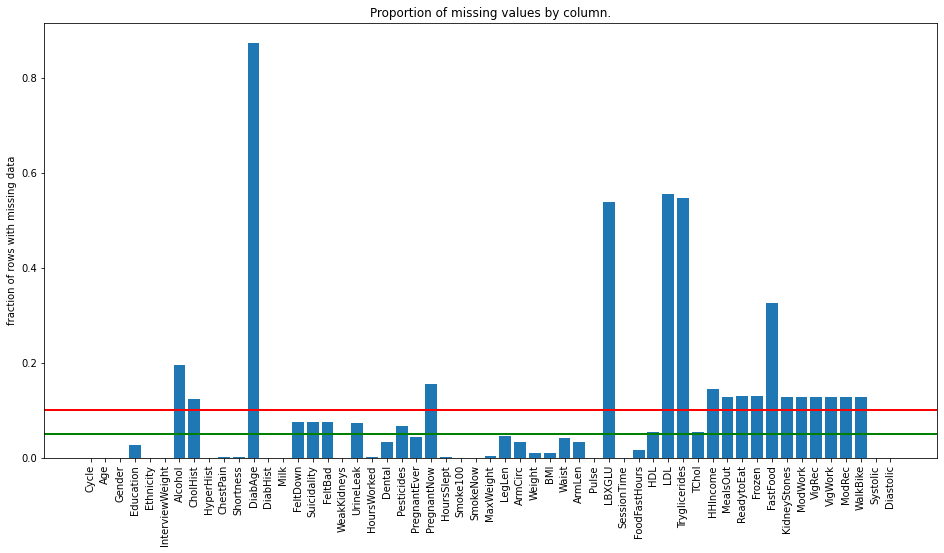

In [5]:
column_fraction_null = col_frac_missing(df,threshold = 0.05)

We can see quite a few columns have missing data over the 5% and 10% threshold. There is a stand out column DiabAge -- the age a person is diagnosed with diabetes -- but of course if someone is never diagnosed this value is missing by design. Therefore we must come back to this column later. Next we will attempt to drop rows missing the most values.

In [6]:
# The laboratory dat will not be used in predictive modeling, we will drop it immediately.

df.drop(['LBXGLU','HDL','LDL','Tryglicerides','TChol'],axis = 1, inplace=True)

## View missing data by row

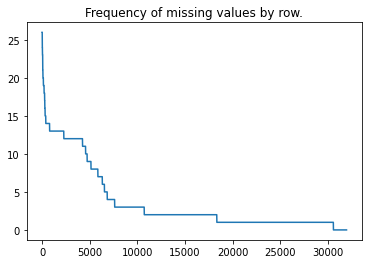

In [7]:
frac_index_null = df.isnull().sum(1).sort_values(ascending = False)

frac_index_null.reset_index()[0].plot()
plt.title('Frequency of missing values by row.')
plt.show()

There seem to be roughly 5000 SPs missing well over 5 values. We will investigate whether dropping such rows improves the missing data by columns.

In [8]:
# Drop SPs missing 5 or more values
df_depleted = df[df.isnull().sum(1)<5]

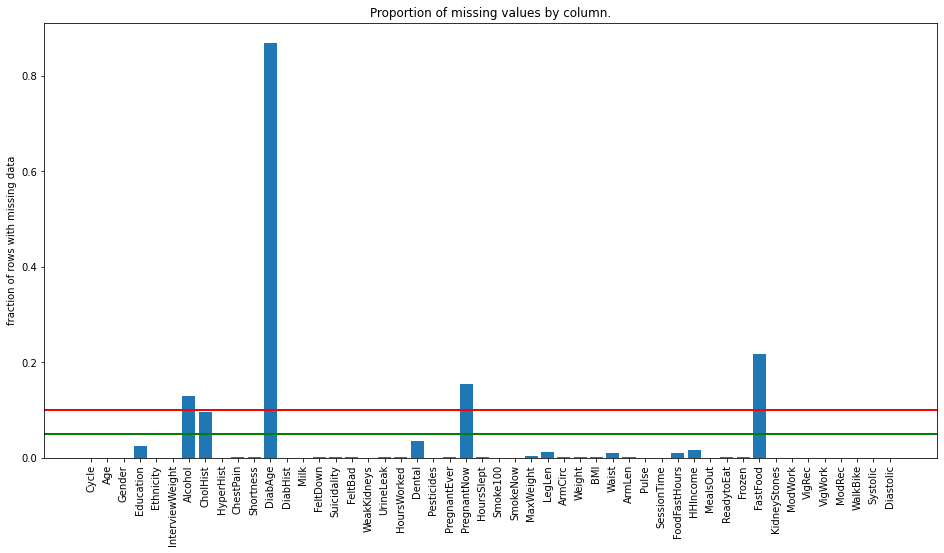

In [9]:
column_fraction_null = col_frac_missing(df_depleted)

We can see LBXGLU, LDL, Triglicerides miss very large number of values. These columns are not part of our predictive analysis, but will be used in exploratory analysis, so we will leave it in for now. FastFood and and PregnantNow are still missing a large numbe of values, so we will drop them from the original dataframe.

## Drop columns with many missing values

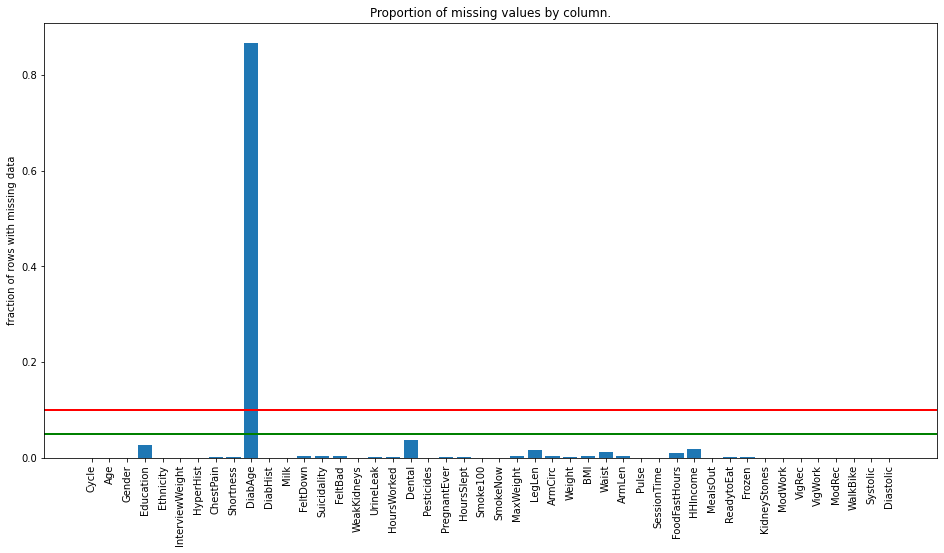

In [10]:
# Drop columns from original dataframe missing many values
df.drop(['Alcohol', 'CholHist','PregnantNow','FastFood'],axis=1,inplace=True)
# Drop SPs missing 5 or more values
df_depleted = df[df.isnull().sum(1)<5].copy()
column_fraction_null = col_frac_missing(df_depleted)

## Fixing the DiabAge variable

In [11]:
x = df['DiabHist'].value_counts()
print(f'SPs not told they have diabetes: {x[0.0]}')
print(f'SPs told they have diabetes: {x[1.0]}')

SPs not told they have diabetes: 27149
SPs told they have diabetes: 4806


The majority of SPs have not been diagnosed with diabetes, which explains the large number of missing values in DiabAge. We will construct a new feature DiabHistAge which combines these two variables.

In [12]:
df_depleted['DiabHistAge'] = 0
df_depleted.loc[(df_depleted['DiabAge'] > 50),'DiabHistAge'] = 1
df_depleted.loc[(df_depleted['DiabAge'] > 50),'DiabHistAge'] = 2
df_depleted.drop(['DiabHist','DiabAge'],axis=1,inplace=True)

Again let us view missing values by column

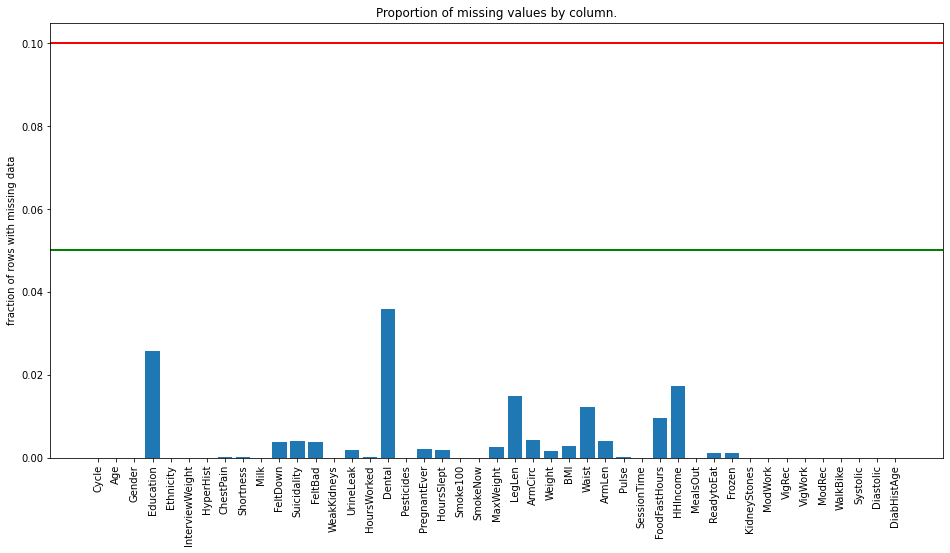

In [13]:
column_fraction_null = col_frac_missing(df_depleted)

In [14]:
n,m=df_depleted.shape

print(f'The dataframe consists of {n} rows and {m} columns.')

The dataframe consists of 25388 rows and 45 columns.


## Split data

In [15]:
from sklearn.model_selection import train_test_split

df_train, df_test = train_test_split(df_depleted, test_size = 0.2)

# Imputations

In [16]:
print('Missing proportions in demographic columns')
column_fraction_null[['Age','Gender','Ethnicity']]

Missing proportions in demographic columns


Age          0.0
Gender       0.0
Ethnicity    0.0
dtype: float64

No values are missing from these demographics columns, so we will attempt to impute by these groups. First we verify which columns are missing sufficiently few values per group. We convert Age to AgeGroup for imputation.

In [17]:
df_train = df_train.join((df_train['Age'].apply(lambda x: np.floor(x/20))).rename('AgeGroup')) 
df_test = df_test.join((df_test['Age'].apply(lambda x: np.floor(x/20))).rename('AgeGroup'))

demo = ['Gender','AgeGroup','Ethnicity']

# Find proportion missing per demographic
min_prop = (df_train.groupby(by = demo).count().apply(lambda x: x/max(x),axis = 1)).min()
max_prop = (df_train.groupby(by = demo).count().apply(lambda x: x/max(x),axis = 1)).max()


In [18]:
print('Columns requiring imputation missing 5% data or less in all demo groups.')
min_prop[(min_prop >= 0.95) & (min_prop < 1)]

Columns requiring imputation missing 5% data or less in all demo groups.


ChestPain       0.997297
Shortness       0.997297
UrineLeak       0.971429
HoursWorked     0.998582
PregnantEver    0.986547
HoursSlept      0.983333
MaxWeight       0.990074
Weight          0.954545
BMI             0.954545
Pulse           0.999218
ReadytoEat      0.994475
Frozen          0.995604
dtype: float64

In [19]:
print('Columns missing over 5% data in at least one demo group.')
min_prop[min_prop < 0.95]

Columns missing over 5% data in at least one demo group.


Education        0.909091
FeltDown         0.909091
Suicidality      0.909091
FeltBad          0.909091
Dental           0.885338
LegLen           0.884615
ArmCirc          0.933333
Waist            0.909091
ArmLen           0.933333
FoodFastHours    0.909091
HHIncome         0.909091
dtype: float64

In [20]:
# Impute by demographic for those demos missing 5% or under per group
demo_impute = min_prop[(min_prop >= 0.95) & (min_prop < 1)].index

for col in demo_impute:
    DemoImputer = GroupImputer(demo, col, metric = 'median')
    DemoImputer.fit(df_train)
    df_train = pd.DataFrame(DemoImputer.transform(df_train),columns = df_train.columns)
    df_test = pd.DataFrame(DemoImputer.transform(df_test),columns = df_test.columns)

The remaining categorical and dietary data will be imputed based on overall aggregates rather than demographic categories.

In [21]:
cat_feats = ['Education',
             'FeltDown',
             'Suicidality',
             'FeltBad',
             'Dental',
             'HHIncome']

for feat in cat_feats:
    df_train[feat] = df_train[feat].fillna(df_train[feat].mode()[0])
    df_test[feat] = df_test[feat].fillna(df_train[feat].mode()[0])

                 

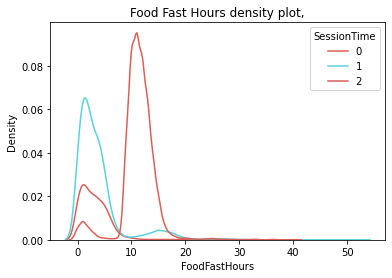

In [22]:
# The session time variable is recorded by survey takers and is missing no values.
# Let us investigate whether we can use it to impute the FoodFastHours variable.

# Fix a coding error:
df_train["SessionTime"] = df_train["SessionTime"].astype(int)
df_test["SessionTime"] = df_train["SessionTime"].astype(int)

sns.kdeplot(data=df_train, x= "FoodFastHours",hue="SessionTime",palette='hls')
plt.title('Food Fast Hours density plot,')
plt.show()

It seems the food fast hours is strongly session time (Morning, Noon, Afternoon) dependent. We will impute using this variable.

In [23]:
FastImputer = GroupImputer(['SessionTime'], 'FoodFastHours', metric = 'median')
FastImputer.fit(df_train)
df_train = pd.DataFrame(FastImputer.transform(df_train),columns = df_train.columns)
df_test = pd.DataFrame(FastImputer.transform(df_test),columns = df_test.columns)

It remains to impute continuous values.

In [24]:
continuous_values = ["LegLen",
                     "ArmCirc",
                     "Waist",
                     "ArmLen"]

print('Proportion missing per column:')

column_fraction_null[continuous_values]

Proportion missing per column:


LegLen     0.014771
ArmCirc    0.004175
Waist      0.012289
ArmLen     0.004096
dtype: float64

We will use the experimental iterative imputer to fill these values.

In [25]:

from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
imp = IterativeImputer(max_iter=10)
imp.fit(df_train)


df_train = pd.DataFrame(imp.transform(df_train),columns = df_train.columns)
df_test = pd.DataFrame(imp.transform(df_test),columns = df_test.columns)


## Finally we save the data

Most of the columns have low numbers of missing values, aside from the laboratory data, which we keep only to study in the EDA, not for the purpose of predictive analysis.

In [26]:
# Split the test set into validation and test sets
df_validation, df_test = train_test_split(df_test, test_size = 0.5)

df_train.to_pickle("df_train.pkl")

df_validation.to_pickle("df_validation.pkl")

df_test.to_pickle("df_test.pkl")
